In [1]:
import numpy as np
from numpy.ma import masked_values as maval
import gsw
import xarray as xr
import pandas as pd
import os.path as op
from datetime import datetime, timedelta
from scipy.interpolate import PchipInterpolator as pchip
from scipy.signal import medfilt
import dask.array as dsar
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib import cm
import matplotlib.colors as clr
import matplotlib.ticker as tick
import matplotlib.path as mpath
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
import cmocean as cmocean
import os

In [3]:
SOCCOM_flt_ids = [12888]

In [4]:
# Load Float Data
HRdir = "/Users/dhruvbalwada/work_root/sogos/data/raw/SOCCOM/manual_download/SOCCOM_HRQC_LIAR_netcdf_20191201/"
LRdir = "/Users/dhruvbalwada/work_root/sogos/data/raw/SOCCOM/manual_download/SOCCOM_LRQC_LIAR_netcdf_20191201/"

float_dic_HR = {}
float_dic_LR = {}

for i in SOCCOM_flt_ids:
    float_dic_HR[i] = xr.open_dataset(HRdir + str(i) + "SOOCN_HRQC.nc")
    float_dic_LR[i] = xr.open_dataset(LRdir + str(i) + "SOOCNQC.nc")

In [8]:
# Load topography
topo = xr.open_dataarray("/Users/dhruvbalwada/work_root/sogos/data/processed/ETOPO1_Ice_g_gmt4_coarsened5.nc")

Text(0.5, 1.0, '12888')

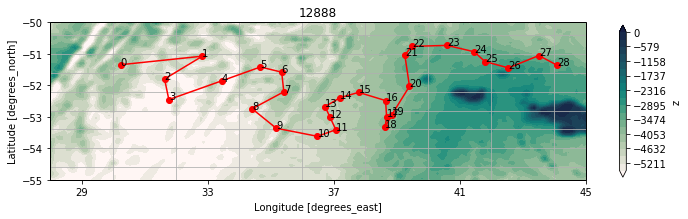

In [35]:
plt.figure(figsize=(12, 7))
plt.tight_layout()
ax = plt.subplot(111, projection=ccrs.PlateCarree())  
# create a set of axes with Mercator projection
ax.set_xticks(np.linspace(29, 49, 6), crs=ccrs.PlateCarree())
ax.set_yticks(np.linspace(-55.0, -50, 6), crs=ccrs.PlateCarree())
ax.set_extent([28, 45, -55, -50])
ax.add_feature(cfeature.COASTLINE)  # plot some data on them
# ax.plot(ds.Lon.values, ds.Lat.values)
# ax.scatter(ds_HR.Lon.values, ds_HR.Lat.values,
#           s=25., c=ds_HR.groupby('JULD').mean().JULD.values,
#               rasterized=True)
topo.sel(y=slice(-65, -40)).sel(x=slice(25, 50)).plot.contourf(
    ax=ax,
    transform=ccrs.PlateCarree(),
    cbar_kwargs={"shrink": 0.4},
    vmin=-4500, vmax=0,
    cmap=cmocean.cm.tempo, levels=np.linspace(-5500,0,20)
)

topo.sel(y=slice(-65, -40)).sel(x=slice(25, 50)).plot.contour(
    ax=ax,
    transform=ccrs.PlateCarree(),
    levels=[0], colors='w'
)

for i in [12888]:
    ax.plot(float_dic_HR[i].Lon.values, float_dic_HR[i].Lat.values, "o-",
            rasterized=True, color='r')
    for j in range(len(float_dic_HR[i].Lon)):
        plt.text(float_dic_HR[i].Lon[j], float_dic_HR[i].Lat[j], str(j))    
    #ax.text(float_dic_HR[i].Lon.values[-1], float_dic_HR[i].Lat.values[-1], str(i))
ax.gridlines()
ax.set_title("12888")  # label it

In [37]:
ds_flt = float_dic_HR[12888]
ds_flt

<xarray.Dataset>
Dimensions:              (NPARAMETER: 46, N_LEVELS: 558, N_PROF: 29)
Dimensions without coordinates: NPARAMETER, N_LEVELS, N_PROF
Data variables:
    Cruise               |S11 ...
    Station              (N_PROF) int32 ...
    Lon                  (N_PROF) float64 30.23 32.83 31.63 ... 43.51 44.08
    Lat                  (N_PROF) float64 -51.34 -51.07 -51.8 ... -51.05 -51.36
    Lat_QF               (N_PROF) |S1 ...
    Lat_QFA              (N_PROF) float64 ...
    Pressure             (N_PROF, N_LEVELS) float64 ...
    Pressure_QF          (N_PROF, N_LEVELS) |S1 ...
    Pressure_QFA         (N_PROF, N_LEVELS) float64 ...
    Temperature          (N_PROF, N_LEVELS) float64 ...
    Temperature_QF       (N_PROF, N_LEVELS) |S1 ...
    Temperature_QFA      (N_PROF, N_LEVELS) float64 ...
    Salinity             (N_PROF, N_LEVELS) float64 ...
    Salinity_QF          (N_PROF, N_LEVELS) |S1 ...
    Salinity_QFA         (N_PROF, N_LEVELS) float64 ...
    Sigma_theta        

In [38]:
dist = gsw.distance(ds_flt.Lon, ds_flt.Lat)
distance = np.cumsum(dist)
distance = np.insert(distance, 0, 0)
ds_flt["distance"] = distance

In [39]:
# Calculate density and spice

## Add density and other things
SA = xr.apply_ufunc(
    gsw.SA_from_SP,
    ds_flt.Salinity,
    ds_flt.Pressure,
    ds_flt.Lon,
    ds_flt.Lat,
    dask="parallelized",
    output_dtypes=[float],
).rename("SA")
CT = xr.apply_ufunc(
    gsw.CT_from_t,
    SA,
    ds_flt.Temperature,
    ds_flt.Pressure,
    dask="parallelized",
    output_dtypes=[float],
).rename("CT")
SIGMA0 = xr.apply_ufunc(
    gsw.sigma0, SA, CT, dask="parallelized", output_dtypes=[float]
).rename("SIGMA0")
SPICE = xr.apply_ufunc(
    gsw.spiciness0, SA, CT, dask="parallelized", output_dtypes=[float]
).rename("SPICE")

ds_flt = xr.merge([ds_flt, SIGMA0, SPICE, SA, CT])

Text(0, 0.5, 'Along Track Distance(km)')

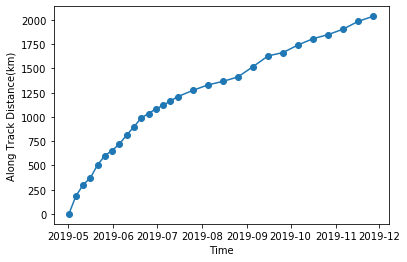

In [40]:
plt.plot(ds_flt.JULD, ds_flt.distance / 1e3, Marker="o")
plt.xlabel("Time")
plt.ylabel("Along Track Distance(km)")

In [83]:
pd.to_datetime(ds_flt.JULD[i].values).month

5

In [42]:
ncasts = len(ds_flt.Lon)

(26.8, 27.6)

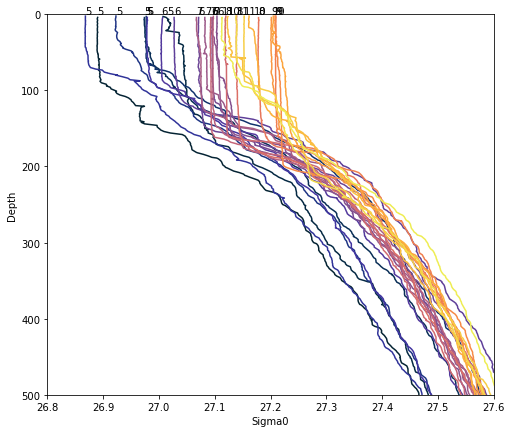

In [92]:
plt.figure(figsize=(8,7))
for i in range(ncasts):
    plt.plot(ds_flt.SIGMA0.isel(N_PROF=i),
        ds_flt.Pressure.isel(N_PROF=i),
        color=cmocean.cm.thermal(i / ncasts))
    
    plt.text(ds_flt.SIGMA0.isel(N_PROF=i)[-20],0, 
             str(pd.to_datetime(ds_flt.JULD[i].values).month))
plt.gca().invert_yaxis()
plt.xlabel('Sigma0')
plt.ylabel('Depth')
plt.ylim([500, 0])
plt.xlim([26.8, 27.6])


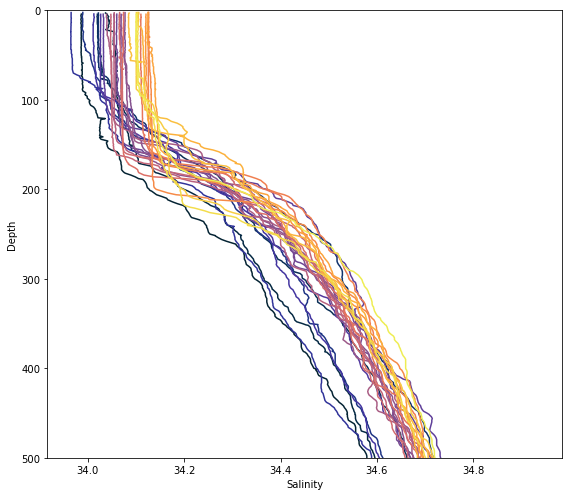

In [55]:
plt.figure(figsize=(8,7))
for i in range(ncasts):
    plt.plot(
        ds_flt.SA.isel(N_PROF=i),
        ds_flt.Pressure.isel(N_PROF=i),
        color=cmocean.cm.thermal(i / ncasts),
    )
plt.gca().invert_yaxis()
plt.xlabel('Salinity')
plt.ylabel('Depth')
plt.ylim([500, 0])
#plt.xlim([26.8, 27.6])
plt.tight_layout()

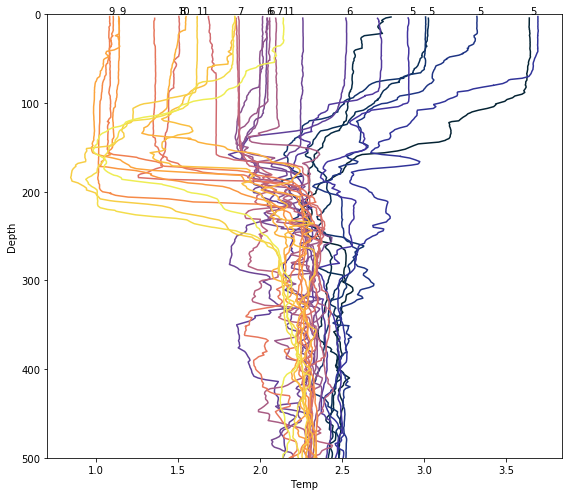

In [96]:
plt.figure(figsize=(8,7))
for i in range(ncasts):
    plt.plot(
        ds_flt.CT.isel(N_PROF=i),
        ds_flt.Pressure.isel(N_PROF=i),
        color=cmocean.cm.thermal(i / ncasts),
    )
    
    if (np.mod(i,2)==0):
        plt.text(ds_flt.CT.isel(N_PROF=i)[-20],0, 
             str(pd.to_datetime(ds_flt.JULD[i].values).month))
plt.gca().invert_yaxis()
plt.xlabel('Temp')
plt.ylabel('Depth')
plt.ylim([500, 0])
#plt.xlim([26.8, 27.6])
plt.tight_layout()

# N2

In [100]:
from scipy.interpolate import PchipInterpolator
# using pchip interpolator because it supposed to be the best! 

In [101]:
def pchip_interp(y, pres, pint):
    pres_temp = -pres[(np.isfinite(pres) & np.isfinite(y))]
    y = y[(np.isfinite(pres) & np.isfinite(y))]

    [pres_unique, unique_ids] = np.unique(pres_temp, return_index=True)

    y = y[unique_ids]

    f = PchipInterpolator(pres_unique, y, extrapolate=False)

    return f(-pint)

In [102]:
Paxis = np.linspace(0, 2000, 1001)

In [103]:
dens_int = np.zeros((len(ds_flt.N_PROF), len(Paxis)))

In [104]:
for i in range(len(ds_flt.N_PROF)):
    dens_int[i, :] = pchip_interp(ds_flt.SIGMA0.isel(N_PROF=i).values,
        ds_flt.Pressure.isel(N_PROF=i).values,Paxis)
dens_int = xr.DataArray(dens_int, coords=[ds_flt.N_PROF, Paxis], dims=['N_PROF', 'Pressure']).rename('SIGMA0')
ds_flt_int = dens_int.to_dataset()    

In [105]:
vars_to_int = ['Temperature', 'Salinity', 'Oxygen', 'OxygenSat', 'Nitrate', 'Chl_a', 
               'Chl_a_corr', 'b_bp700', 'POC', 'pHinsitu', 'TALK_LIAR', 'DIC_LIAR']

In [106]:
temp_int = np.zeros((len(ds_flt.N_PROF), len(Paxis)))
for var in vars_to_int: 
    for i in range(len(ds_flt.N_PROF)):
        temp_int[i, :] = pchip_interp(ds_flt[var].isel(N_PROF=i).values,
            ds_flt.Pressure.isel(N_PROF=i).values,Paxis) 
        
    ds_temp_int = xr.DataArray(temp_int, coords=[ds_flt.N_PROF, Paxis], dims=['N_PROF', 'Pressure']).rename(var)

    ds_flt_int[var] = ds_temp_int.copy()

In [107]:
dist = xr.DataArray(distance, coords=[ds_flt.N_PROF], dims='N_PROF')

In [108]:
ds_flt_int =ds_flt_int.assign_coords(dist=dist)

In [110]:
from xgcm import generate_grid_ds, Grid

In [111]:
ds_flt_int = generate_grid_ds(ds_flt_int, {'Z':'Pressure'} )
grid = Grid(ds_flt_int)

In [112]:
g=9.81
rho0=1000

In [113]:
ds_flt_int['N2'] = grid.interp(g/rho0 * grid.diff(ds_flt_int.SIGMA0, 'Z', boundary='extend') / 
                    grid.diff(ds_flt_int.Pressure, 'Z', boundary='extend'), 'Z', boundary='extend')

In [114]:
def find_mld(dens):
    dens10 = dens.interp(Pressure = 10.)
    
    delta_dens = dens - dens10
    delta_dens_crit = delta_dens.where(delta_dens>=0.03)
    
    MLD = delta_dens.Pressure.where(delta_dens==delta_dens_crit.min(['Pressure'])).max(['Pressure']).rename('mld')
    
    return MLD

In [115]:
MLD = find_mld(ds_flt_int.SIGMA0)
ds_flt_int['MLD'] = MLD

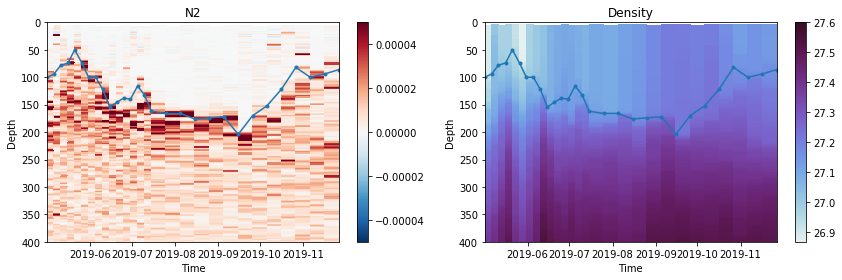

In [116]:
plt.figure(figsize=(12,4))
plt.subplot(121)
plt.pcolormesh(ds_flt.JULD, ds_flt_int.Pressure, ds_flt_int.N2.T, 
               vmin=-5e-5, vmax=5e-5, cmap='RdBu_r')
plt.plot(ds_flt.JULD, ds_flt_int.MLD, Marker='.')

plt.gca().invert_yaxis()
plt.ylim([400, 0])
plt.colorbar()
plt.xlabel('Time')
plt.ylabel('Depth')
plt.title('N2')

plt.subplot(122)
plt.pcolormesh(ds_flt.JULD, ds_flt_int.Pressure, ds_flt_int.SIGMA0.T, 
                cmap=cmocean.cm.dense, vmax=27.6)
plt.plot(ds_flt.JULD, ds_flt_int.MLD, Marker='.')

plt.gca().invert_yaxis()
plt.ylim([400, 0])
plt.colorbar()
plt.xlabel('Time')
plt.ylabel('Depth')
plt.title('Density')

plt.tight_layout()

#plt.savefig('../figures/12888_N2_dens.png')

In [127]:
ds_flt.JULD

<xarray.DataArray 'JULD' (N_PROF: 29)>
array(['2019-05-01T08:59:00.000003584', '2019-05-06T03:48:59.999995648',
       '2019-05-11T01:38:59.999997952', '2019-05-16T04:09:00.000004608',
       '2019-05-21T01:30:59.999996416', '2019-05-26T04:19:59.999995648',
       '2019-05-31T01:16:59.999996160', '2019-06-05T04:21:00.000002048',
       '2019-06-10T01:41:59.999997440', '2019-06-15T04:09:00.000004608',
       '2019-06-20T01:44:00.000000256', '2019-06-25T04:21:00.000002048',
       '2019-06-30T01:43:00.000003840', '2019-07-05T04:23:00.000004864',
       '2019-07-10T01:41:00.000000768', '2019-07-15T04:19:59.999995648',
       '2019-07-25T13:47:59.999995904', '2019-08-04T22:55:59.999997440',
       '2019-08-15T08:00:59.999999744', '2019-08-25T15:17:59.999995904',
       '2019-09-05T02:46:59.999996160', '2019-09-15T11:34:59.999998976',
       '2019-09-25T18:56:00.000000768', '2019-10-06T03:22:00.000001792',
       '2019-10-16T11:15:59.999996416', '2019-10-26T20:03:59.999999232',
       '2019

In [137]:
time = pd.to_datetime(ds_flt.JULD.values).month + pd.to_datetime(ds_flt.JULD.values).day/30

In [138]:
time

Float64Index([ 5.033333333333333,                5.2,  5.366666666666666,
               5.533333333333333,                5.7,  5.866666666666667,
               6.033333333333333,  6.166666666666667,  6.333333333333333,
                             6.5,  6.666666666666667,  6.833333333333333,
                             7.0,  7.166666666666667,  7.333333333333333,
                             7.5,  7.833333333333333,  8.133333333333333,
                             8.5,  8.833333333333334,  9.166666666666666,
                             9.5,  9.833333333333334,               10.2,
              10.533333333333333, 10.866666666666667,               11.2,
              11.533333333333333, 11.866666666666667],
             dtype='float64')

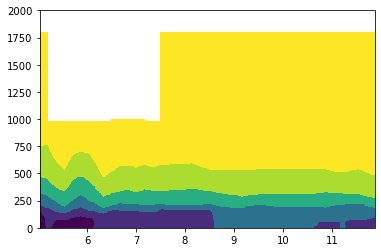

In [139]:
plt.contourf(time, ds_flt_int.Pressure, ds_flt_int.SIGMA0.T, 
                 vmin=27, vmax=27.6)

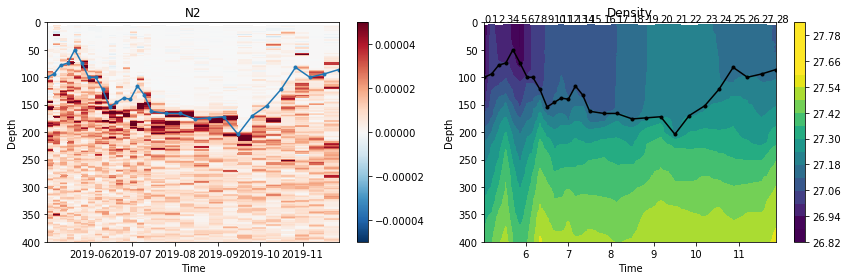

In [155]:
plt.figure(figsize=(12,4))
plt.subplot(121)
plt.pcolormesh(ds_flt.JULD, ds_flt_int.Pressure, ds_flt_int.N2.T, 
               vmin=-5e-5, vmax=5e-5, cmap='RdBu_r')
plt.plot(ds_flt.JULD, ds_flt_int.MLD, Marker='.')

plt.gca().invert_yaxis()
plt.ylim([400, 0])
plt.colorbar()
plt.xlabel('Time')
plt.ylabel('Depth')
plt.title('N2')

plt.subplot(122)
plt.contourf(time, ds_flt_int.Pressure, ds_flt_int.SIGMA0.T, 
                 vmin=26.9, vmax=27.6, levels=15 )
plt.plot(time, ds_flt_int.MLD, Marker='.', color='k')

for i in range(len(time)):
    plt.text(time[i], 0 , str(i))
#plt.plot(ds_flt.JULD, ds_flt_int.MLD, Marker='.')

plt.gca().invert_yaxis()
plt.ylim([400, 0])
plt.colorbar()
plt.xlabel('Time')
plt.ylabel('Depth')
plt.title('Density')

plt.tight_layout()

Text(0.5, 1.0, 'Temp')

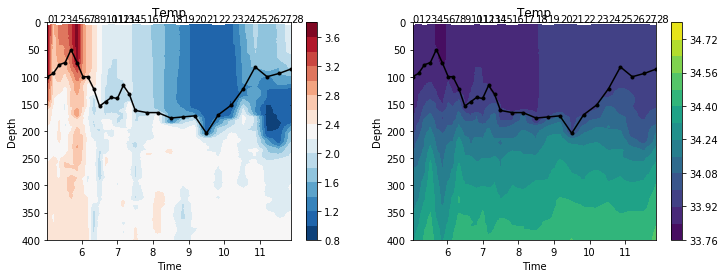

In [156]:
plt.figure(figsize=(12,4))

plt.subplot(121)
plt.contourf(time, ds_flt_int.Pressure, ds_flt_int.Temperature.T, 
                  levels=15 , cmap='RdBu_r')
plt.plot(time, ds_flt_int.MLD, Marker='.', color='k')
for i in range(len(time)):
    plt.text(time[i], 0 , str(i))
    
plt.gca().invert_yaxis()
plt.ylim([400, 0])
plt.colorbar()
plt.xlabel('Time')
plt.ylabel('Depth')
plt.title('Temp')    
    
plt.subplot(122)
plt.contourf(time, ds_flt_int.Pressure, ds_flt_int.Salinity.T, 
                  levels=15 )
plt.plot(time, ds_flt_int.MLD, Marker='.', color='k')
for i in range(len(time)):
    plt.text(time[i], 0 , str(i))

plt.gca().invert_yaxis()
plt.ylim([400, 0])
plt.colorbar()
plt.xlabel('Time')
plt.ylabel('Depth')
plt.title('Temp')    
        

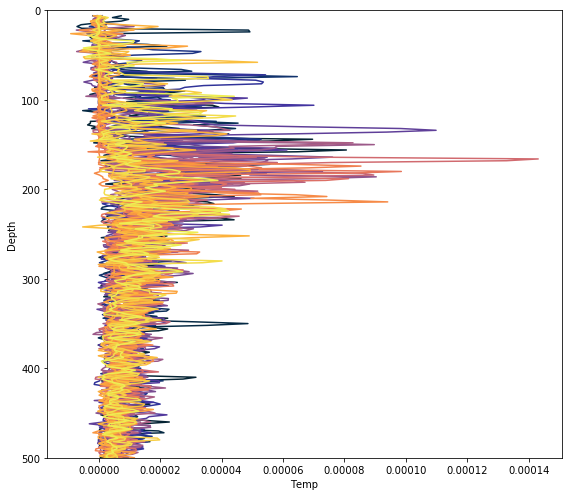

In [121]:
plt.figure(figsize=(8,7))
for i in range(ncasts):
    plt.plot(
        ds_flt_int.N2.isel(N_PROF=i),
        ds_flt_int.Pressure,
        color=cmocean.cm.thermal(i / ncasts),
    )
    
plt.gca().invert_yaxis()
plt.xlabel('Temp')
plt.ylabel('Depth')
plt.ylim([500, 0])
#plt.xlim([26.8, 27.6])
plt.tight_layout()